## Model runs, data, and analysis routines for exploring the "Ligand-Iron-Microbe" feedback (Lauderdale, Braakman, Forget, Dutkiewicz, and Follows)

<img src="ligand_feedback.png" width="350" />

Given the organic origin of iron-binding ligands, we hypothesize that a positive feedback between microbial activity, ligand abundance, and iron availability could emerge. 
Iron is supplied by dust deposition, sediment mobilization, and hydrothermal activity. 
In a hypothetical watermass where ligand abundance is initially very low, Fe(III) is largely insoluble, but a small population of microbes subsist. Their turnover produces ligands such as siderophores, excreted organic carbon, or chelating detritus. Greater ligand abundance retains more iron in solution, incrementally relieving iron limitation, promoting further biological production, and so on.
Eventually, other requirements such as macronutrients, become limiting, and additional iron no longer increases productivity. At appropriate time and space scales, the global ligand pool is regulated, supporting "just enough" iron to match availability of other resources redistributed by ocean circulation, maximizing overall nutrient consumption and global productivity. 

In [1]:
import csv
import matplotlib.pyplot as plt
import cmocean           as cm
import matplotlib        as mp
import numpy             as np
import numpy.ma          as nm
import pandas            as pd
from matplotlib.ticker     import FormatStrFormatter
from itertools             import zip_longest

# nutboxmod provides "model" which is the fortran model compiled with "f2py"
import importlib.util
spec = importlib.util.spec_from_file_location("nutboxmod", "/Users/jml1/GitHub/Lauderdale_ligand_iron_microbe_feedback/nutboxmod.cpython-37m-darwin.so")
nutboxmod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(nutboxmod)

import utils

**Set to True, the script will call the box model ninc^2 times (must have compiled boxmodel.f with f2py,  an ensemble of integrations could take a long time), set to False and it will skip to the plotting**

In [2]:
RUNMODEL=False

## 1. Model parameters and initial conditions

<img src="boxmodel_schematic.png" width="350" />

The box model has three boxes linked by an overturning circulation: an upwelling box with low iron input analagous to HNLC regions like the Southern Ocean, and a deep water formation region with significant iron input analagous to the Atlantic Ocean. Iron-binding ligands are produced by organic matter turnover, and lost by microbial degradation.

In [3]:
# Number of increments in parameter space
nincs=100

# Fixed value for uniform ligand control experiment
fixedligconc=1.0

# Do the analysis using nitrate (NP=16) or native phosphate (NP=1)
R_np=16

# Convert mol/kg to mol/m3
conv = 1024.5 

finname ='boxmodel_input.csv'
foutname='boxmodel_output.csv'

figfmt='pdf'
#figfmt='eps'
           
# Total number of model runs in ensemble
niters=nincs*nincs

# Start counting the model runs at ninit
ninit =0

# Box dimensions (m)
dx=np.array([17.0e6, 17.0e6, 17.0e6]) 
dy=np.array([ 3e6,   13e6, 16.0e6]) 
dz=np.array([50.0,   50.0, 5050.0]) 

area = dx * dy 
vol= area * dz 
invol = 1.0 / vol

psi=20.0e6 # Sv

# Biological production maximum rate per year
alpha_yr=6e-6

**Surface iron input rate (Atlantic receives 1.00xdep [g/m2/yr] while SO receives 0.01xdep)**

Default value (7.0) is taken from the box model paper (Table 1) in Parekh et al (2004).

 Data from Mahowald et al (2006) suggests:

--Whole NA: 0.25 gFE m-2 yr-1

--0 to 20N: 0.40 gFE m-2 yr-1

--20N ++  : 0.16 gFE m-2 yr-1

--40N ++  : 0.10 gFE m-2 yr-1

--Whole SO: 0.0015 gFE m-2 yr-1

--Whole SH: 0.0033 gFE m-2 yr-1


In [4]:
# Dust deposition in g Fe m-2 year-1
dustdep=0.15
# Hydrothermal vent input of 1 Gmol/yr (Tagliabue et al., 2010)
# mol Fe/yr * g/mol * 1/area  == g Fe m-2 year-1....divide by 2.5e-3 because fe_sol is multiplied again within the box model.
ventdep=(1e9*56)/(area[2]*0.0025)

**Assign gamma and lambda parameters systematically to cover parameter space. Use log spacing to get good data coverage at the really small values**

In [5]:
#gamma_fe is in phosphate units, not carbon units...divide by RCP=106 to get values referenced in paper
# lt_rate is in years, then converted to seconds
grid_lt_rate,grid_gamma=np.meshgrid(np.geomspace(0.1,1000,nincs),np.geomspace(1e-5,10,nincs))
gamma_fe = grid_gamma.flatten()
lt_rate  = grid_lt_rate.flatten()*3.0e7

gamma_over_lambda=(gamma_fe[:niters]/106)/(1/lt_rate[:niters]) # Lambda needs to be 1/s

# Deep ocean box lifetime modifier - capture the gradient introduced by photodegradation near the surface and slower loss in the deep ocean
dlambdadz=0.01

**Assign random initial values of macronutrients, iron, and ligands**

In [6]:
# Phosphate has to be conserved (convert to mol/m3 before volume integrating)
pinv=nm.sum(np.array((2.1, 2.1, 2.1)) * conv * 1.0e-6 * vol)

# Each row of boxfrac sums to 1 (also generate random value for control run with fixed, uniform ligand concentration)
boxfrac=np.random.dirichlet(np.ones(3),size=(niters))

# Each row of parray now contains randomly assigned fractions of the same total phosphate pool (umol/kg)
parray=(boxfrac*pinv)/(vol*conv*1e-6)

# Remainder of initial conditions randomly allocated as nmol/kg (also generate random value for control run)
farray=np.random.randint(0,100,size=(niters,3)).astype(np.double)
larray=np.random.randint(0,100,size=(niters,3)).astype(np.double)

**Define global output arrays**

In [7]:
ncost=np.ones((niters,1))
fcost=np.ones((niters,1))
lcost=np.ones((niters,1))
pstar=np.ones((niters,1))
    
nsurfmean=np.ones((niters,1))
fsurfmean=np.ones((niters,1))
lsurfmean=np.ones((niters,1))
 
export=np.ones((niters,1))
expbox=np.ones((niters,2))

nlimit=np.ones((niters,1))
  
# Box 1: Southern Ocean
nso=np.ones((niters,1))
fso=np.ones((niters,1))
lso=np.ones((niters,1))

# Box 2: North Atlantic
nna=np.ones((niters,1))
fna=np.ones((niters,1))
lna=np.ones((niters,1))
    
# Box 3: Deep Ocean
ndo=np.ones((niters,1))
fdo=np.ones((niters,1))
ldo=np.ones((niters,1))


**Get reference values for model-data comparison**

In [8]:
# Print out objective function reference values
PRINTREF=True

if R_np==16:
    woafile='woa13_annual_nitrate.nc'
else:
    woafile='woa13_annual_phosphate.nc'

nref, nstd = utils.get_macro_reference(woafile,Rnp=R_np)
    
idpfile='GEOTRACES_IDP2017_v2_Discrete_Sample_Data.nc'

fref, fstd, lref, lstd = utils.get_micro_reference(idpfile)

# number of obs used in objective function - 3 boxes and 3 variables (weighted equally)
nobs=nm.masked_invalid(nref).count()+nm.masked_invalid(fref).count()+nm.masked_invalid(lref).count()

if PRINTREF:   
    # Print out reference values
    if R_np==16:
        print('Nitrate reference values are: ',np.str(np.round(nref,3)))
        print('Nitrate st. deviation values are: ',np.str(np.round(nstd,3)))
    else:
        print('Phosphate reference values are: ',np.str(np.round(nref,3)))
        print('Phosphate st. deviation values are: ',np.str(np.round(nstd,3)))
    print('Total Iron reference values are: ',np.str(np.round(fref,3)))
    print('Total Iron st. deviation values are: ',np.str(np.round(fstd,3)))
    print('Total Ligand reference values are: ',np.str(np.round(lref,3)))
    print('Total Ligand st. deviation values are: ',np.str(np.round(lstd,3)))

Nitrate reference values are:  [[23.974  2.958 31.621]]
Nitrate st. deviation values are:  [[ 3.688  5.073 11.495]]
Total Iron reference values are:  [[0.249 0.288 0.69 ]]
Total Iron st. deviation values are:  [[0.439 0.347 2.311]]
Total Ligand reference values are:  [[1.872 1.972 2.374]]
Total Ligand st. deviation values are:  [[1.006 0.896 3.364]]


## 2. MODEL OUTPUT: Run experiments that save the output to a file, or load previous runs from files.

In [9]:
if RUNMODEL: # Only run the model if true.
    ## %% Write input values to a file for future reference (not the control)
    # The initial conditions are also written out at the start of the model output
    print("Running new model ensemble...this may take some time, O(2days) for 10,000 simulations")
    cvs_d=np.concatenate((parray[:niters],farray[:niters],larray[:niters],gamma_fe[:niters,np.newaxis]/106,lt_rate[:niters,np.newaxis]/3e7,gamma_over_lambda[:niters,np.newaxis]),axis=1)
    export_data = zip_longest(*cvs_d.T, fillvalue = '')
    with open(finname, 'w', encoding="ISO-8859-1", newline='') as myfile:
          wr = csv.writer(myfile)
          if R_np==16:
              wr.writerow(("N1","N2","N3","F1","F2","F3","L1","L2","L3","gamma","1/lambda","gamma_over_lambda"))
          else:
              wr.writerow(("P1","P2","P3","F1","F2","F3","L1","L2","L3","gamma","1/lambda","gamma_over_lambda"))
          wr.writerows(export_data)
    myfile.close()
    
# Run experiments
    utils.run_boxmodel_iter(parray,farray,larray,gamma_fe,lt_rate,
                      dustdep,ventdep,alpha_yr,psi,dlambdadz,niters,ninit,
                      nref,nstd,fref,fstd,lref,lstd,area,Rnp=R_np)
    
# Save the output as another csv file
    cvs_d=np.concatenate((nso,nna,ndo,fso,fna,fdo,lso,lna,ldo,ncost,fcost,lcost,nlimit,expbox,pstar),axis=1)
    export_data = zip_longest(*cvs_d.T, fillvalue = '')
    with open(foutname, 'w', encoding="ISO-8859-1", newline='') as myfile:
          wr = csv.writer(myfile)
          wr.writerow(("nso","nna","ndo","fso","fna","fdo","lso","lna","ldo","ncost","fcost","lcost","nlimit","export1","export2","pstar"))
          wr.writerows(export_data)
    myfile.close()   
    
    gamma      = gamma_fe[:niters,np.newaxis]/106
    inv_lambda = lt_rate[:niters,np.newaxis]/3e7
    gamma_over_lambda = gamma_over_lambda[:niters,np.newaxis]
    
    exp1=expbox[:,0][:,np.newaxis]
    exp2=expbox[:,1][:,np.newaxis]
else:
# Load the results from file
    try:
        data_inp = pd.read_csv(finname,skiprows=0,header=0, 
                           names=["n1","n2","n3","f1","f2","f3","l1","l2","l3","gamma","inv_lambda","gamma_over_lambda"])
        data_out = pd.read_csv(foutname,skiprows=0,header=0, 
                           names=["nso","nna","ndo","fso","fna","fdo","lso","lna","ldo","ncost","fcost","lcost","nlimit","export1","export2","pstar"])
        
        print("Loading previous model ensemble from CSV files "+finname+" and "+foutname+"...")
        # Split pandas DF into seperate columns
        for ivar in np.arange(len(data_inp.columns)):
            locals()[data_inp.columns[ivar]]=data_inp[data_inp.columns[ivar]].to_numpy(copy=True)[:,np.newaxis]
    
        for ivar in np.arange(len(data_out.columns)):
            locals()[data_out.columns[ivar]]=data_out[data_out.columns[ivar]].to_numpy(copy=True)[:,np.newaxis]
            
        # calcualte total export, and global surface mean values (already GtC/yr)
        export=(data_out.export1+data_out.export2).to_numpy()[:,np.newaxis]
        expbox=np.array((data_out.export1,data_out.export2))
        
        exp1=expbox[0,:][:,np.newaxis]
        exp2=expbox[1,:][:,np.newaxis]
        
        nsurfmean=np.array((data_out.nso*area[0]+data_out.nna*area[1])/(area[0]+area[1]))[:,np.newaxis] # *R_np have to be careful here
        fsurfmean=np.array((data_out.fso*area[0]+data_out.fna*area[1])/(area[0]+area[1]))[:,np.newaxis]
        lsurfmean=np.array((data_out.lso*area[0]+data_out.lna*area[1])/(area[0]+area[1]))[:,np.newaxis]
    except FileNotFoundError:
        try:
            data_inp = pd.read_csv(finname,skiprows=0,header=0, 
                           names=["n1","n2","n3","f1","f2","f3","l1","l2","l3","gamma","inv_lambda","gamma_over_lambda"])
            
            print("Loading previous model ensemble from model files...")
            
            # Split pandas DF into seperate columns
            for ivar in np.arange(len(data_inp.columns)):
                locals()[data_inp.columns[ivar]]=data_inp[data_inp.columns[ivar]].to_numpy(copy=True)[:,np.newaxis]
            
            fname='ironmodel'
            utils.read_boxmodel_iter(ninit,niters,nref,nstd,fref,fstd,lref,lstd,area,fprefix=fname,Rnp=R_np)
            
            
        except FileNotFoundError:
            print('Could not find CSV or DAT model output! Confirm filenames or set RUNMODEL to "True"')
            raise

Loading previous model ensemble from CSV files boxmodel_input.csv and boxmodel_output.csv...


## 3. ANALYSIS: Calculate observational range, model-data comparison score, bulk ligand residence time, and uniform ligand benchmark value

In [10]:
# Model-data comparison score
jovern = np.exp(-1*(ncost+fcost+lcost)/nobs) 
# Seperate contributions (multiply to recover full score)
jovernn = np.exp(-1*(ncost)/nobs) 
jovernf = np.exp(-1*(fcost)/nobs) 
jovernl = np.exp(-1*(lcost)/nobs) 

# Run a control experiment with fixed 1nm ligand concentration
pincntrl=(np.random.dirichlet(np.ones(3),size=(1))*pinv)/(vol*conv*1e-6)
fincntrl=np.random.randint(0,100,size=(1,3)).astype(np.double)
lincntrl=np.tile(fixedligconc,(1,3))

tcntrl,pcntrl,fcntrl,lcntrl,epcntrl,nlcntrl,pscntrl = nutboxmod.model(1e4,10,
                    pincntrl*1.0e-6,fincntrl*1.0e-9,lincntrl*1.0e-9,0.0,0.0,
                    dustdep,ventdep,alpha_yr,dlambdadz,psi,niters)

tlen=np.int(1e4/10)
ncostcntrl=utils.calc_cost(np.array((pcntrl[0,tlen]*R_np,pcntrl[1,tlen]*R_np,pcntrl[2,tlen]*R_np)),nref,nstd)
fcostcntrl=utils.calc_cost(np.array((fcntrl[0,tlen]     ,fcntrl[1,tlen]     ,fcntrl[2,tlen])),fref,fstd)
lcostcntrl=utils.calc_cost(np.array((lcntrl[0,tlen]     ,lcntrl[1,tlen]     ,lcntrl[2,tlen])),lref,lstd)

jovern_fixed1nmlig=np.exp(-1*(ncostcntrl+fcostcntrl+lcostcntrl)/nobs) 

# Seperate contributions (multiply to recover full jovern)
jovernn_fixed1nmlig = np.exp(-1*(ncostcntrl)/nobs) 
jovernf_fixed1nmlig = np.exp(-1*(fcostcntrl)/nobs) 
jovernl_fixed1nmlig = np.exp(-1*(lcostcntrl)/nobs) 

pstar_fixed1nmlig =pscntrl[tlen]
export_fixed1nmlig=(epcntrl[0,tlen]+epcntrl[1,tlen])*117*86400*365*12*1e-15
nlimit_fixed1nmlig=nlcntrl[tlen]

# Calculate the data-based constraint of gamma/lambda
data_goverl,range_goverl=utils.calc_gamma_over_lambda_range()

# What is an estimate of ligand residence time?
# Order of magnitude for gamma is 1e-5 to 1e-4 (Voelker and Tagliabue, 2015)
ltrest=np.sort(np.array((
        np.min((np.tile(10**data_goverl,(2,1))/np.tile(np.array((1e-5,1e-4))[:,np.newaxis],(1,2)))),
        np.max((np.tile(10**data_goverl,(2,1))/np.tile(np.array((1e-5,1e-4))[:,np.newaxis],(1,2))))
        ))/(86400*365))

# Get medians of model results along lambda/gamma contours
gaovla_average=np.geomspace(0.1,1e10,2*nincs)

# Bin the data according to equal/similar values for gamma/lambda by MEDIAN/MADEV
# tried Mean and STDev instead, prety much the same plot, did require quite a lot of arbitrary babysitting
idx             = np.digitize(gamma_over_lambda,gaovla_average,right=True)
nens            = np.asarray([np.count_nonzero(idx[idx==ivar]) for ivar in range(len(gaovla_average))])
jovern_average  = np.asarray([np.median(jovern   [idx==ivar])  for ivar in range(len(gaovla_average))])
jovernn_average = np.asarray([np.median(jovernn  [idx==ivar])  for ivar in range(len(gaovla_average))])
jovernf_average = np.asarray([np.median(jovernf  [idx==ivar])  for ivar in range(len(gaovla_average))])
jovernl_average = np.asarray([np.median(jovernl  [idx==ivar])  for ivar in range(len(gaovla_average))])
pstar_average   = np.asarray([np.median(pstar    [idx==ivar])  for ivar in range(len(gaovla_average))])
nsurf_average   = np.asarray([np.median(nsurfmean[idx==ivar])  for ivar in range(len(gaovla_average))])
fsurf_average   = np.asarray([np.median(fsurfmean[idx==ivar])  for ivar in range(len(gaovla_average))])
lsurf_average   = np.asarray([np.median(lsurfmean[idx==ivar])  for ivar in range(len(gaovla_average))])
nso_average     = np.asarray([np.median(nso      [idx==ivar])  for ivar in range(len(gaovla_average))])
fso_average     = np.asarray([np.median(fso      [idx==ivar])  for ivar in range(len(gaovla_average))])
lso_average     = np.asarray([np.median(lso      [idx==ivar])  for ivar in range(len(gaovla_average))])
nna_average     = np.asarray([np.median(nna      [idx==ivar])  for ivar in range(len(gaovla_average))])
fna_average     = np.asarray([np.median(fna      [idx==ivar])  for ivar in range(len(gaovla_average))])
lna_average     = np.asarray([np.median(lna      [idx==ivar])  for ivar in range(len(gaovla_average))])
ndo_average     = np.asarray([np.median(ndo      [idx==ivar])  for ivar in range(len(gaovla_average))])
fdo_average     = np.asarray([np.median(fdo      [idx==ivar])  for ivar in range(len(gaovla_average))])
ldo_average     = np.asarray([np.median(ldo      [idx==ivar])  for ivar in range(len(gaovla_average))])
exp_average     = np.asarray([np.median(export   [idx==ivar])  for ivar in range(len(gaovla_average))])
exp1_average    = np.asarray([np.median(exp1     [idx==ivar])  for ivar in range(len(gaovla_average))])
exp2_average    = np.asarray([np.median(exp2     [idx==ivar])  for ivar in range(len(gaovla_average))])
jovern_spread   = np.asarray([utils.mad(jovern   [idx==ivar])  for ivar in range(len(gaovla_average))])
jovernn_spread  = np.asarray([utils.mad(jovernn  [idx==ivar])  for ivar in range(len(gaovla_average))])
jovernf_spread  = np.asarray([utils.mad(jovernf  [idx==ivar])  for ivar in range(len(gaovla_average))])
jovernl_spread  = np.asarray([utils.mad(jovernl  [idx==ivar])  for ivar in range(len(gaovla_average))])
pstar_spread    = np.asarray([utils.mad(pstar    [idx==ivar])  for ivar in range(len(gaovla_average))])
nsurf_spread    = np.asarray([utils.mad(nsurfmean[idx==ivar])  for ivar in range(len(gaovla_average))])
fsurf_spread    = np.asarray([utils.mad(fsurfmean[idx==ivar])  for ivar in range(len(gaovla_average))])
lsurf_spread    = np.asarray([utils.mad(lsurfmean[idx==ivar])  for ivar in range(len(gaovla_average))])
exp_spread      = np.asarray([utils.mad(export   [idx==ivar])  for ivar in range(len(gaovla_average))])
exp1_spread     = np.asarray([utils.mad(exp1     [idx==ivar])  for ivar in range(len(gaovla_average))])
exp2_spread     = np.asarray([utils.mad(exp2     [idx==ivar])  for ivar in range(len(gaovla_average))])

# Region of gamma/lambda where macro- and micro-nutrients co-limit production in different spatial regions
colimits=np.array((\
       np.min(np.log10(gaovla_average[np.log10(nso_average)==np.nanmin(np.log10(nso_average))])),
       np.max(np.log10(gaovla_average[exp_average<=2.0]))
       ))

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in less_equal


## 4. PLOTS

In [11]:
mp.rcParams['xtick.labelsize'] = 14
mp.rcParams['ytick.labelsize'] = 14 

len_xaxis,len_yaxis = 4,4 #fix here your numbers
xspace, yspace = .9, .9 # change the size of the void border here.
x_fig,y_fig = len_xaxis / xspace, len_yaxis / yspace

**Fig3: Model illustration using single timeseries**

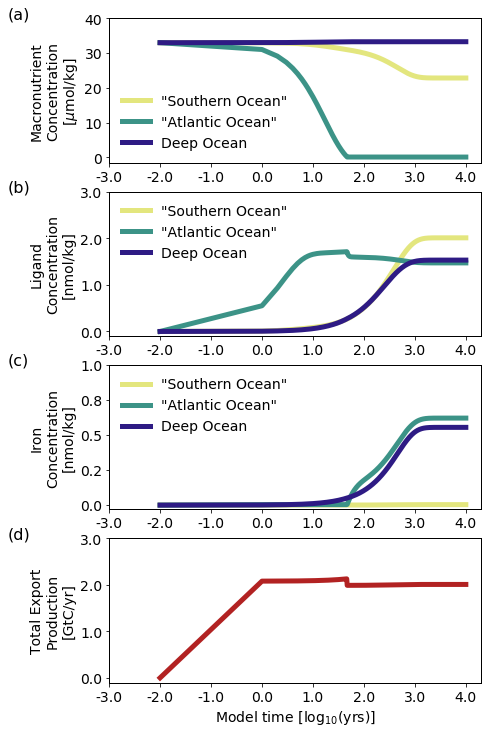

In [12]:
example_gaovla = 4500
example_gamma  = np.array((5e-5*106,))
example_lambda = np.array((1/((example_gamma/106)/example_gaovla)))

pinexample=np.tile(33/R_np,(1,3))
finexample=np.tile(1e-6,(1,3))
linexample=np.tile(1e-6,(1,3))

texample,pexample,fexample,lexample,epexample,nlexample,psexample = nutboxmod.model(1e4,1,
                    pinexample*1.0e-6,finexample*1.0e-9,linexample*1.0e-9,
                    example_gamma,example_lambda,
                    dustdep,ventdep,alpha_yr,dlambdadz,psi,niters+1)

tlen=np.int(1e4/1)

timeseries_tim=texample[:tlen]*1
timeseries_nso=pexample[0,:tlen]*R_np
timeseries_nna=pexample[1,:tlen]*R_np
timeseries_ndo=pexample[2,:tlen]*R_np
timeseries_fso=fexample[0,:tlen]
timeseries_fna=fexample[1,:tlen]
timeseries_fdo=fexample[2,:tlen]
timeseries_lso=lexample[0,:tlen]
timeseries_lna=lexample[1,:tlen]
timeseries_ldo=lexample[2,:tlen]
timeseries_exp=(epexample[0,:tlen]+epexample[1,:tlen])*117*86400*365*12*1e-15 # convert molP/s to GtC/yr

# Make sure initial conditions are included at t~0
timeseries_tim[0]=timeseries_tim[0]+.01

#Plot the timeseries
fig3, (f3ax1,f3ax2,f3ax3,f3ax4) = plt.subplots(figsize=(1.5*x_fig, 2.75*y_fig),ncols=1,nrows=4)
fig3.patch.set_facecolor('None')
mycm = plt.cm.get_cmap(cm.cm.haline)

# Phosphate
## SO
f3ax1.plot(np.log10(timeseries_tim),timeseries_nso,color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO
f3ax1.plot(np.log10(timeseries_tim),timeseries_nna,color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# DO
f3ax1.plot(np.log10(timeseries_tim),timeseries_ndo,color=mycm(10),linewidth=5,label="Deep Ocean")
f3ax1.legend(frameon=False,fontsize=14)
f3ax1.set_ylim(top=np.ceil(np.max(f3ax1.get_ylim())/10)*10)
f3ax1.set_xlim(left=-3)
f3ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax1.set_ylabel("Macronutrient\nConcentration\n[$\mu$mol/kg]",fontsize=14)
f3ax1.text(-5,np.max(f3ax1.get_ylim()),'(a)',fontsize=16)

# Ligands
# SO
f3ax2.plot(np.log10(timeseries_tim),timeseries_lso,color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO 
f3ax2.plot(np.log10(timeseries_tim),timeseries_lna,color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# DO
f3ax2.plot(np.log10(timeseries_tim),timeseries_ldo,color=mycm(10),linewidth=5,label="Deep Ocean")
f3ax2.legend(frameon=False,fontsize=14)
f3ax2.set_ylim(top=3)
f3ax2.set_xlim(left=-3)
f3ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax2.set_ylabel("Ligand\nConcentration\n[nmol/kg]",fontsize=14)
#f3ax2.set_xlabel("Model time [log$_{10}$(yrs)]",fontsize=14)
f3ax2.text(-5,np.max(f3ax2.get_ylim()),'(b)',fontsize=16)

# Iron
# SO
f3ax3.plot(np.log10(timeseries_tim),timeseries_fso,color=mycm(240),linewidth=5,label="\"Southern Ocean\"")
# AO
f3ax3.plot(np.log10(timeseries_tim),timeseries_fna,color=mycm(128),linewidth=5,label="\"Atlantic Ocean\"")
# DO
f3ax3.plot(np.log10(timeseries_tim),timeseries_fdo,color=mycm(10),linewidth=5,label="Deep Ocean")
f3ax3.legend(frameon=False,fontsize=14)
f3ax3.set_ylim(top=np.ceil(np.max(f3ax3.get_ylim())))
f3ax3.set_xlim(left=-3)
f3ax3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax3.set_ylabel("Iron\nConcentration\n[nmol/kg]",fontsize=14)
f3ax3.text(-5,np.max(f3ax3.get_ylim()),'(c)',fontsize=16)

f3ax4.plot(np.log10(timeseries_tim),timeseries_exp,color='firebrick',linewidth=5,label="\"Southern\"+\"Atlantic\"")
#f3ax4.legend(frameon=False,fontsize=14)
f3ax4.set_ylim(top=np.ceil(np.max(f3ax4.get_ylim())))
f3ax4.set_xlim(left=-3)
f3ax4.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax4.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax4.set_ylabel("Total Export\nProduction\n[GtC/yr]",fontsize=14)
f3ax4.set_xlabel("Model time [log$_{10}$(yrs)]",fontsize=14)
f3ax4.text(-5,np.max(f3ax4.get_ylim()),'(d)',fontsize=16)

plt.show()     
fig3.savefig('illustration_of_feedback.'+figfmt,format=figfmt,facecolor=fig3.get_facecolor(), edgecolor='none',bbox_inches='tight')
plt.close()

Initially, the model is iron limited globally with elevated macronutrients in both "Atlantic Ocean" and "Southern Ocean" surface boxes (a). Relatively high iron delivery to the "Atlantic Ocean" box leads to an initial rise in productivity (d) and depletion of surface macronutrients. This drives ligand production (b), allowing accumulation of a standing stock of deep ocean iron (c). In the following centuries, macronutrients stay depleted with elevated productivity, and ligand levels converge towards steady state due to transport and loss processes. 

In contrast, lower iron input to the "Southern Ocean" box cannot support rapid macronutrient drawdown. On longer timescales, as ligand levels increase throughout the ocean, upwelled chelated iron drives a gradual incomplete reduction of surface macronutrients. 

Steady state is reached after 1000 years. The "Southern Ocean" box is iron-limited (c) with incomplete macronutrient use (a) fueled by iron supply from the deep ocean, while the "Atlantic Ocean" box is macronutrient limited, with sufficient iron to fully consume macronutrients primarily delivered by the overturning circulation.

An emergent positive feedback promotes global-scale iron and macronutrient co-limitation.

**Figure 4: 10,000 model simulations nutrient and export fluxes**

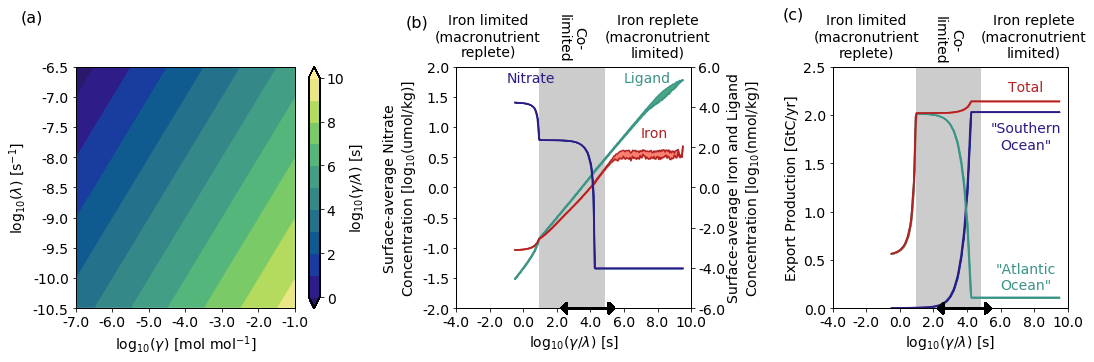

In [13]:
grid_gam   =   np.reshape(gamma,np.shape(grid_gamma))
grid_lt    =1/(np.reshape(inv_lambda ,np.shape(grid_gamma))*3e7)
grid_gaovla=   np.reshape(gamma_over_lambda,np.shape(grid_gamma))

fig4, (f4ax1,f4ax2,f4ax3) = plt.subplots(figsize=(4*x_fig, y_fig),ncols=3,gridspec_kw={'width_ratios': [1.4, 1.2, 1.2]})
fig4.patch.set_facecolor('None')
mycm = plt.cm.get_cmap(cm.cm.haline)

f4ax1c1=f4ax1.contourf(np.log10(grid_gam),np.log10(grid_lt),np.log10(grid_gaovla),np.arange(0,11,1),cmap=mycm,vmin=0,vmax=10,extend='both')
# This is the fix for the white lines between contour levels
for a in f4ax1.collections:
    a.set_edgecolor("face")

f4cbar1=fig4.colorbar(f4ax1c1,ax=f4ax1,ticks=np.arange(0,12.0,2.0),extend='both')
f4cbar1.solids.set_edgecolor("face")
f4cbar1.set_label('log$_{10}(\gamma/\lambda)$ [s]',fontsize=14)
f4ax1.set_ylabel('log$_{10}(\lambda)$ [s$^{-1}$]',fontsize=14)
f4ax1.set_xlabel('log$_{10}(\gamma)$ [mol mol$^{-1}$]',fontsize=14)
f4ax1.set_xlim(left=-7,right=-1)
f4ax1.xaxis.set_ticks(np.arange(-7,0,1))
f4ax1.set_ylim(bottom=-10.5,top=-6.5)
f4ax1.yaxis.set_ticks(np.arange(-10.5,-6,0.5))
f4ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax1.text(-8.5,-5.75,'(a)',fontsize=16)
    
# Macronutrients
f4ax2.plot(np.log10(gaovla_average),np.log10(np.maximum(nsurf_average-nsurf_spread,0.021)),color=mycm(10))
f4ax2.plot(np.log10(gaovla_average),np.log10(nsurf_average+nsurf_spread),color=mycm(10))
f4ax2.fill_between(np.log10(gaovla_average),np.log10(np.maximum(nsurf_average-nsurf_spread,0.021)),np.log10(nsurf_average+nsurf_spread),color=mycm(50))

f4ax2.set_xlabel('log$_{10}(\gamma/\lambda)$ [s]',fontsize=14)
f4ax2.set_xlim(left=-4,right=10)
f4ax2.xaxis.set_ticks(np.arange(-4,12,2))
f4ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax2.set_ylim(bottom=-2,top=2)

# Change plot appearence
if R_np==16:
    f4ax2.set_ylabel('Surface-average Nitrate\nConcentration [log$_{10}$(umol/kg)]',fontsize=14)
    f4ax2.text(np.min(np.log10(gaovla_average)),np.max(f4ax2.get_ylim())-0.25,'Nitrate',color=mycm(10),fontsize=14)
else:
    f4ax2.set_ylabel('Surface-average Phosphate\nConcentration [log$_{10}$(umol/kg)]',fontsize=14)
    f4ax2.text(np.log10(gaovla_average),np.max(f4ax2.get_ylim())-0.3,'Phosphate',color=mycm(10),fontsize=14)


# Second axes for Macronutrients that shares the same x-axis
f4ax2a = f4ax2.twinx()  
# Ligands
f4ax2a.plot(np.log10(gaovla_average),np.log10(lsurf_average-lsurf_spread),color=mycm(128))
f4ax2a.plot(np.log10(gaovla_average),np.log10(lsurf_average+lsurf_spread),color=mycm(128))
f4ax2a.fill_between(np.log10(gaovla_average),np.log10(lsurf_average-lsurf_spread),np.log10(lsurf_average+lsurf_spread),color=mycm(150))
# Iron
f4ax2a.plot(np.log10(gaovla_average),np.log10(fsurf_average-fsurf_spread),'firebrick')
f4ax2a.plot(np.log10(gaovla_average),np.log10(fsurf_average+fsurf_spread),'firebrick')
f4ax2a.fill_between(np.log10(gaovla_average),np.log10(fsurf_average-fsurf_spread),np.log10(fsurf_average+fsurf_spread),color='salmon')

# Change plot appearence
f4ax2a.set_ylim(bottom=-6,top=6)
f4ax2a.set_ylabel('Surface-average Iron and Ligand\nConcentration [log$_{10}$(nmol/kg)]',fontsize=14)
f4ax2a.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Co limitation zone
f4ax2a.fill_between((colimits[0],colimits[1]),
                  np.min(f4ax2a.get_ylim()), np.max(f4ax2a.get_ylim()),color='#cccccc',zorder=-1)

#Change the overlay order
f4ax2.set_zorder(f4ax2.get_zorder()+1)
f4ax2a.patch.set_visible(True)
f4ax2.patch.set_visible(False)

# Labels
f4ax2a.text(-7,np.max(f4ax2a.get_ylim())+2.0,'(b)',fontsize=16)
f4ax2a.text(7,np.max(f4ax2a.get_ylim())-3.5,'Iron',color='firebrick',fontsize=14)
f4ax2a.text(6,np.max(f4ax2a.get_ylim())-.75,'Ligand',color=mycm(128),fontsize=14)
f4ax2a.text(8,np.max(f4ax2a.get_ylim())+.5,'Iron replete\n(macronutrient\nlimited)',horizontalalignment='center',fontsize=14)
f4ax2a.text((colimits[1]+colimits[0])/2,np.max(f4ax2a.get_ylim())+1.3,'Co-\nlimited',rotation=-90,horizontalalignment='center',fontsize=14)
f4ax2a.text(-2.1,np.max(f4ax2a.get_ylim())+.5,'Iron limited\n(macronutrient\nreplete)',horizontalalignment='center',fontsize=14)

# Plot data-based constraint of gamma/lambda
f4ax2a.annotate(s='', xy=(np.max(data_goverl),np.min(f4ax2a.get_ylim())), xytext=(np.min(data_goverl),np.min(f4ax2a.get_ylim())), arrowprops=dict(color='black',arrowstyle='<|-|>,head_width=0.5,head_length=0.5', shrinkA=0, shrinkB=0, linewidth=2))

# Plot median export values in each basin
f4ax3.plot(np.log10(gaovla_average),exp1_average-exp1_spread,color=mycm(10))
f4ax3.plot(np.log10(gaovla_average),exp1_average+exp1_spread,color=mycm(10),label="Southern")
f4ax3.fill_between(np.log10(gaovla_average),(exp1_average-exp1_spread),(exp1_average+exp1_spread),color=mycm(50))

f4ax3.plot(np.log10(gaovla_average),exp2_average-exp2_spread,color=mycm(128))
f4ax3.plot(np.log10(gaovla_average),exp2_average+exp2_spread,color=mycm(128),label="Northern")
f4ax3.fill_between(np.log10(gaovla_average),(exp2_average-exp2_spread),(exp2_average+exp2_spread),color=mycm(150))

f4ax3.plot(np.log10(gaovla_average),exp_average-exp_spread,'firebrick')
f4ax3.plot(np.log10(gaovla_average),exp_average+exp_spread,'firebrick',label="Total")
f4ax3.fill_between(np.log10(gaovla_average),(exp_average-exp_spread),(exp_average+exp_spread),color='salmon')

# Change plot appearence
f4ax3.set_ylabel('Export Production [GtC/yr]',fontsize=14)
f4ax3.set_xlabel('log$_{10}$($\gamma/\lambda$) [s]',fontsize=14)
f4ax3.set_xlim(left=-4,right=10)
f4ax3.xaxis.set_ticks(np.arange(-4,12,2))
f4ax3.set_ylim(bottom=0.0,top=2.5)
f4ax3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Plot data-based constraint of gamma/lambda
f4ax3.annotate(s='', xy=(np.max(data_goverl),np.min(f4ax3.get_ylim())), xytext=(np.min(data_goverl),np.min(f4ax3.get_ylim())), arrowprops=dict(color='black',arrowstyle='<|-|>,head_width=0.5,head_length=0.5', shrinkA=0, shrinkB=0, linewidth=2))

f4ax3.text(-7,np.max(f4ax3.get_ylim())+0.5,'(c)',fontsize=16)
f4ax3.text(7.5,2.25,'Total',color='firebrick',horizontalalignment='center',fontsize=14)
f4ax3.text(7.5,1.65,'\"Southern\nOcean\"',color=mycm(10),horizontalalignment='center',fontsize=14)
f4ax3.text(7.5,0.2,'\"Atlantic\nOcean\"',color=mycm(128),horizontalalignment='center',fontsize=14)
f4ax3.text(8,1.04*np.max(f4ax3.get_ylim()),'Iron replete\n(macronutrient\nlimited)',horizontalalignment='center',fontsize=14)
f4ax3.text((colimits[1]+colimits[0])/2,1.1*np.max(f4ax3.get_ylim()),'Co-\nlimited',rotation=-90,horizontalalignment='center',fontsize=14)
f4ax3.text(-2,1.04*np.max(f4ax3.get_ylim()),'Iron limited\n(macronutrient\nreplete)',horizontalalignment='center',fontsize=14)

# Co limitation zone
f4ax3.fill_between((colimits[0],colimits[1]),
                  np.min(f4ax3.get_ylim()), np.max(f4ax3.get_ylim()),color='#cccccc',zorder=-1)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.5)

# Manuallly move fig (b) left a bit
pos = f4ax2.get_position().bounds
tmp=pos[0]-0.075*pos[2]
f4ax2.set_position([tmp,pos[1],pos[2],pos[3]])

plt.show()     
fig4.savefig('ensemble_nutrients_export_plot.'+figfmt,format=figfmt,facecolor=fig4.get_facecolor(), edgecolor='none',bbox_inches='tight')
plt.close()

It is notable that the concentrations and rates of microbial production converge to a tight curve as a function of gamma/lambda while representing numerous combinations of individual gamma and lambda values, as well as a range of random arbitrary initial conditions. In other words, the outcomes are robust and predictable for any given gamma/lambda, and independent of initial conditions: the feedback restores the degree of biological limitation between macronutrients and iron for the specific value of gamma/lambda.

Guided by these data, the experiments can be partitioned into three regimes: 
(i) iron-replete (macronutrient limited) simulations, (ii) iron-limited (macronutrient replete) simulations, and (iii) iron and macronutrient co-limited simulations (region shaded grey).

**Figure 5: 10,000 model simulations model-data comparison**

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less_equal
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in less_equal
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in less_equal


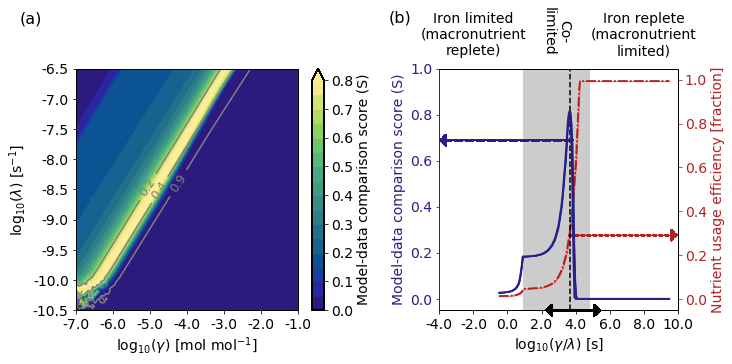

In [14]:
jgrid =np.reshape(jovern,np.shape(grid_gamma))
pgrid =np.reshape(pstar ,np.shape(grid_gamma))

fig5, (f5ax1,f5ax2) = plt.subplots(figsize=(2.5*x_fig, y_fig),ncols=2,gridspec_kw={'width_ratios': [1.4,1.2]})
#fig5, (f5ax1,f5ax2,f5ax3) = plt.subplots(figsize=(4*x_fig, y_fig),ncols=3,gridspec_kw={'width_ratios': [1.4, 1.2, 1.2]})

fig5.patch.set_facecolor('None')

f5ax1c1=f5ax1.contourf(np.log10(grid_gam),np.log10(grid_lt),jgrid,np.arange(0,0.85,0.05),cmap=mycm,vmin=0,vmax=0.8,extend='max')
for a in f5ax1.collections:
    a.set_edgecolor("face")
f5cbar1=fig5.colorbar(f5ax1c1,ax=f5ax1,ticks=np.arange(0,0.9,0.1),extend='max')
f5cbar1.solids.set_edgecolor("face")
f5cbar1.set_label('Model-data comparison score (S)',fontsize=14)

# Contour macronutrient use efficiency
f5ax1c2=f5ax1.contour(np.log10(grid_gam),np.log10(grid_lt),pgrid,levels=(0.2,0.4,0.9),colors='gray')
f5ax1.clabel(f5ax1c2,(0.2,0.4,0.9), inline=True, fmt='%.1f', fontsize=12,manual=[(-5.5, -8.25), (-4.75,-8.5), (-4,-8.5)],colors='gray')

f5ax1.set_ylabel('log$_{10}(\lambda)$ [s$^{-1}$]',fontsize=14)
f5ax1.set_xlabel('log$_{10}(\gamma)$ [mol mol$^{-1}$]',fontsize=14)
f5ax1.set_xlim(left=-7,right=-1)
f5ax1.xaxis.set_ticks(np.arange(-7,0,1))
f5ax1.set_ylim(bottom=-10.5,top=-6.5)
f5ax1.yaxis.set_ticks(np.arange(-10.5,-6,0.5))
f5ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f5ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f5ax1.text(-8.5,-5.75,'(a)',fontsize=16)

# Plot vertical lines for lambda/gamma value that minimizes the cost function
f5ax2.axvline(np.log10(gaovla_average[np.nanargmax(jovern_average)]),linestyle='--',color='black')

# Plot Objective function values
f5ax2.plot(np.log10(gaovla_average),jovern_average-jovern_spread,color=mycm(10))
f5ax2.plot(np.log10(gaovla_average),jovern_average+jovern_spread,color=mycm(10))
f5ax2.fill_between(np.log10(gaovla_average), jovern_average-jovern_spread,jovern_average+jovern_spread,color=mycm(50))
     
# Change plot appearence
f5ax2.set_ylabel('Model-data comparison score (S)',fontsize=14)
f5ax2.set_xlabel('log$_{10}$($\gamma/\lambda$) [s]',fontsize=14)
f5ax2.set_xlim(left=-4,right=10)
f5ax2.xaxis.set_ticks(np.arange(-4,12,2))
f5ax2.set_ylim(bottom=-0.05,top=1)
f5ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Plot horizontal line where cost function uses the value for 1nm fixed ligand concentration
f5ax2.annotate(s='', xy=(np.min(f5ax2.get_xlim()),jovern_fixed1nmlig,), xytext=(np.log10(np.min(gaovla_average[np.logical_and(gaovla_average>gaovla_average[np.nanargmax(jovern_average)],jovern_average<=jovern_fixed1nmlig)])),jovern_fixed1nmlig), arrowprops=dict(color=mycm(10),linestyle='--',arrowstyle='-|>,head_width=0.5,head_length=0.5',shrinkA=0, shrinkB=0, linewidth=2))

# Plot data-based constraint of gamma/lambda
f5ax2.annotate(s='', xy=(np.max(data_goverl),np.min(f5ax2.get_ylim())), xytext=(np.min(data_goverl),np.min(f5ax2.get_ylim())), arrowprops=dict(color='black',arrowstyle='<|-|>,head_width=0.5,head_length=0.5', shrinkA=0, shrinkB=0, linewidth=2))

f5ax2.text(-7,1.2,'(b)',fontsize=16)
f5ax2.text(8,1.06,'Iron replete\n(macronutrient\nlimited)',horizontalalignment='center',fontsize=14)
f5ax2.text((colimits[1]+colimits[0])/2,1.15,'Co-\nlimited',rotation=-90,horizontalalignment='center',fontsize=14)
f5ax2.text(-2,1.06,'Iron limited\n(macronutrient\nreplete)',horizontalalignment='center',fontsize=14)

# Change color of y-axis and labels
f5ax2.spines['left'].set_color(mycm(10))
f5ax2.yaxis.label.set_color(mycm(10))
f5ax2.tick_params(axis='y', colors=mycm(10))

# Second axes for P* that shares the same x-axis
f5ax2a = f5ax2.twinx()
plt.plot(np.log10(gaovla_average),(pstar_average-pstar_spread),color='firebrick',linestyle='-.')
plt.plot(np.log10(gaovla_average),(pstar_average+pstar_spread),color='firebrick',linestyle='-.')
plt.fill_between(np.log10(gaovla_average),(pstar_average-pstar_spread),(pstar_average+pstar_spread),color='salmon')
f5ax2a.set_ylabel('Nutrient usage efficiency [fraction]',fontsize=14)  
f5ax2a.set_ylim(bottom=-0.05,top=1.05)

# Change color of y-axis and labels
f5ax2a.spines['right'].set_color('firebrick')
f5ax2a.yaxis.label.set_color('firebrick')
f5ax2a.tick_params(axis='y', colors='firebrick')

# Optimum model macronutrient usage efficiency
f5ax2a.annotate(s='', xy=(np.max(f5ax2a.get_xlim()),pstar_average[np.nanargmax(jovern_average)],), xytext=(np.log10(gaovla_average[np.nanargmax(jovern_average)]),pstar_average[np.nanargmax(jovern_average)]), arrowprops=dict(color='firebrick',linestyle=':',arrowstyle='-|>,head_width=0.5,head_length=0.5', shrinkA=0, shrinkB=0, linewidth=2))

# The range for macronutrient usage efficiency values bounded by jovern>=jovern_fixed1nmlig is 
pstar_range=np.array((\
                np.max(pstar_average[np.logical_and(gaovla_average<gaovla_average[np.nanargmax(jovern_average)],jovern_average<=jovern_fixed1nmlig)]),
                np.min(pstar_average[np.logical_and(gaovla_average>gaovla_average[np.nanargmax(jovern_average)],jovern_average<=jovern_fixed1nmlig)])
                ))

# Co limitation zone
f5ax2a.fill_between((colimits[0],colimits[1]),
                  np.min(f5ax2a.get_ylim()), np.max(f5ax2a.get_ylim()),color='#cccccc',zorder=-1)

# move ax in front
f5ax2.set_zorder(f5ax2a.get_zorder() + 1)
f5ax2.patch.set_visible(False)

'''
f5ax3.plot(np.log10(gaovla_average),jovernl_average-jovernl_spread,color=mycm(128))
f5ax3.plot(np.log10(gaovla_average),jovernl_average+jovernl_spread,color=mycm(128))
f5ax3.fill_between(np.log10(gaovla_average), jovernl_average-jovernl_spread, jovernl_average+jovernl_spread,color=mycm(150))
#f5ax3.axhline(jovern_lsep_fixed1nmlig,linestyle='--',color='orange')
f5ax3.plot(np.log10(gaovla_average),jovernf_average-jovernf_spread,'firebrick',zorder=3)
f5ax3.plot(np.log10(gaovla_average),jovernf_average+jovernf_spread,'firebrick',zorder=3)
f5ax3.fill_between(np.log10(gaovla_average), jovernf_average-jovernf_spread, jovernf_average+jovernf_spread,color='salmon',zorder=3)
#f5ax3.axhline(jovern_fsep_fixed1nmlig,linestyle='--',color='red')
f5ax3.plot(np.log10(gaovla_average),jovernn_average-jovernn_spread,color=mycm(10),zorder=3)
f5ax3.plot(np.log10(gaovla_average),jovernn_average+jovernn_spread,color=mycm(10),zorder=3)
f5ax3.fill_between(np.log10(gaovla_average), jovernn_average-jovernn_spread, jovernn_average+jovernn_spread,color=mycm(50),zorder=3)
#f5ax3.axhline(jovern_nsep_fixed1nmlig,linestyle='--',color='blue')

# Plot vertical lines for lambda/gamma value that minimizes the cost function
f5ax3.axvline(np.log10(gaovla_average[np.nanargmax(jovern_average)]),linestyle='--',color='black')

# Plot horizontal lines for the fixed 1nm control run
f5ax3.axhline(jovernn_fixed1nmlig,linestyle='--',color=mycm(10))
f5ax3.axhline(jovernf_fixed1nmlig,linestyle='--',color='firebrick')
f5ax3.axhline(jovernl_fixed1nmlig,linestyle='--',color=mycm(128))

# Plot data-based constraint of gamma/lambda
f5ax3.annotate(s='', xy=(np.max(data_goverl),np.min(f5ax2.get_ylim())), xytext=(np.min(data_goverl),np.min(f5ax2.get_ylim())), arrowprops=dict(color='black',arrowstyle='<|-|>,head_width=0.5,head_length=0.5', shrinkA=0, shrinkB=0, linewidth=2))

f5ax3.set_ylabel('Model-data comparison score (S)',fontsize=14)
f5ax3.set_xlabel('log$_{10}$($\gamma/\lambda$) [s]',fontsize=14)
f5ax3.set_xlim(left=-4,right=10)
f5ax3.xaxis.set_ticks(np.arange(-4,12,2))
f5ax3.set_ylim(bottom=-0.05,top=1)
f5ax3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Co limitation zone
f5ax3.fill_between((colimits[0],colimits[1]),
                  np.min(f5ax2a.get_ylim()), np.max(f5ax2a.get_ylim()),color='#cccccc',zorder=-1)

if R_np==16:
    f5ax3.text(-1,0,'Nitrate',color=mycm(10),horizontalalignment='center',fontsize=14)
else:
    f5ax3.text(-1,0,'Phosphate',color=mycm(10),horizontalalignment='center',fontsize=14)

f5ax3.text(-1,0.82,'Iron',color='firebrick',horizontalalignment='center',fontsize=14)
f5ax3.text(-1,0.3,'Ligand',color=mycm(128),horizontalalignment='center',fontsize=14)


f5ax3.text(-7,1.2,'(c)',fontsize=16)
f5ax3.text(8,1.06,'Iron replete\n(macronutrient\nlimited)',horizontalalignment='center',fontsize=14)
f5ax3.text((colimits[1]+colimits[0])/2,1.15,'Co-\nlimited',rotation=-90,horizontalalignment='center',fontsize=14)
f5ax3.text(-2,1.06,'Iron limited\n(macronutrient\nreplete)',horizontalalignment='center',fontsize=14)
'''
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.4)

# Manuallly move fig (b) left a bit
pos = f5ax2.get_position().bounds
tmp=pos[0]-0.075*pos[2]
f5ax2.set_position([tmp,pos[1],pos[2],pos[3]])

plt.show()
fig5.savefig('ensemble_model_data_plot.'+figfmt,format=figfmt,facecolor=fig5.get_facecolor(), edgecolor='none',bbox_inches='tight')
plt.close()

We scored ensemble members by quantitative comparison to oceanic observations (S: possible range 0--1).
Scores were compared to a benchmark evaluated from a model simulation where ligand concentration was held fixed at a uniform, global value of 1nM. Dynamic ligand simulations with model-data comparison scores greater than the benchmark value are outperforming the standard parameterization. The best scores are obtained in a band of intermediate gamma/lambda with moderate levels of macronutrients, iron, and ligands. 

Macronutrient use efficiency was diagnosed as the fraction of macronutrients transported from the surface to the deep by biological activity. Efficiency of macronutrient use is positively correlated with gamma/lambda, and reflects the pattern of export production in the low iron, upwelling "Southern Ocean" box.